110.527 medical appointments its 14 associated variables (characteristics). The most important one if the patient show-up or no-show to the appointment. Variable names are self-explanatory, if you have doubts, just let me know!

scholarship variable means this concept = https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia

14 variables

Data Dictionary
01 - PatientId
Identification of a patient
02 - AppointmentID
Identification of each appointment
03 - Gender
Male or Female . Female is the greater proportion, woman takes way more care of they health in comparison to man.
04 - DataMarcacaoConsulta
The day of the actuall appointment, when they have to visit the doctor.
05 - DataAgendamento
The day someone called or registered the appointment, this is before appointment of course.
06 - Age
How old is the patient.
07 - Neighbourhood
Where the appointment takes place.
08 - Scholarship
True of False . Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
09 - Hipertension
True or False
10 - Diabetes
True or False
Alcoholism
True or False
Handcap
True or False
SMS_received
1 or more messages sent to the patient.
No-show
True or False.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier



from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from collections import Counter


Using TensorFlow backend.


In [3]:
os.chdir("../soheil")


noshow = pd.read_csv('KaggleV2-May-2016.csv')

#noshow = pd.read_csv('../input/noshowappointments/KaggleV2-May-2016.csv')

In [4]:
#04 - DataMarcacaoConsulta
# The day of the actuall appointment, when they have to visit the doctor.
# 05 - DataAgendamento
# The day someone called or registered the appointment, this is before appointment of course.

noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


noshow['Scheduled'] = pd.to_datetime(noshow['ScheduledDay'])

#testing skewness
skewness_model={'Age': noshow.Age,
               'Scholarship': noshow.Scholarship,
                'Hipertension': noshow.Hipertension,
                'Diabetes': noshow.Diabetes,
                'Alcoholism':noshow.Alcoholism,
                'Handcap': noshow.Handcap,
                'SMS_received':noshow.SMS_received
               }

for keys, items in skewness_model.items():
    print(keys,"\n")
    print((np.log1p(items)).skew())

noshow['Day of Week'] = noshow['AppointmentDay'].Period()

noshow.drop(columns = ['PatientId', 'AppointmentID'], inplace =True)

In [5]:
#There is no missing value.
noshow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
noshow.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [7]:
noshow.describe(include='O')

,Gender,ScheduledDay,AppointmentDay,Neighbourhood,No-show
count,110527,110527,110527,110527,110527
unique,2,103549,27,81,2
top,F,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,JARDIM CAMBURI,No
freq,71840,24,4692,7717,88208


In [8]:
#Remove negative Age from Dataset
noshow = noshow[noshow['Age']>0]

In [9]:
# Let’s check if there are duplicated data

np.sum(noshow.duplicated())

0

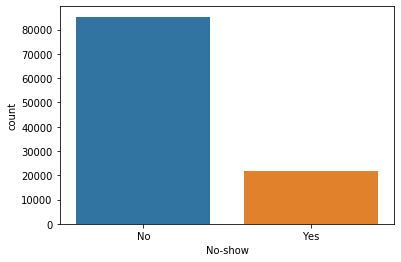

In [10]:
#the distribution of “No-Show” and “Shop-up” cases
sns.countplot(x='No-show', data=noshow)
plt.show()

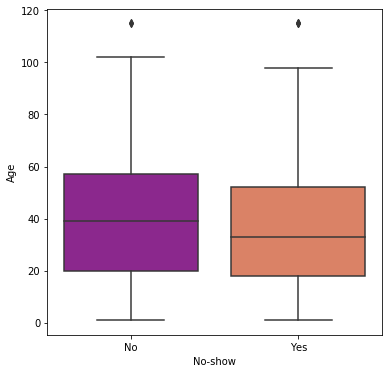

In [11]:
plt.figure(figsize=(6,6))
sns.boxplot(x="No-show", y="Age", data=noshow, palette='plasma')
plt.show()

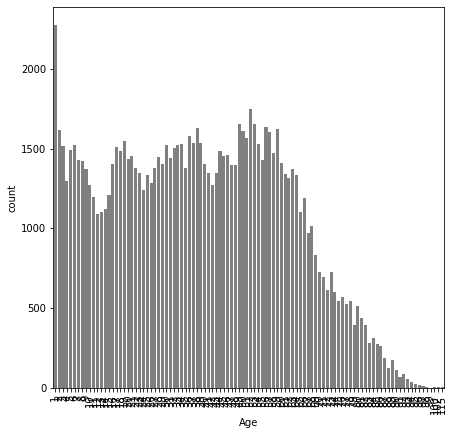

In [12]:
#??? check this part 

plt.figure(figsize=(7,7))
sns.countplot(noshow['Age'],color='gray')
plt.xticks(rotation=90)

plt.show()

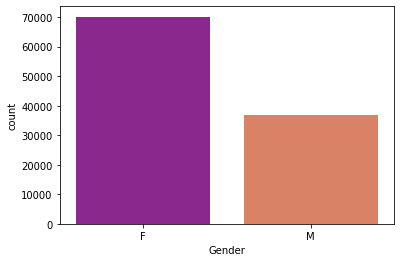

In [13]:
sns.countplot(x='Gender', data=noshow, palette = 'plasma')
plt.show()

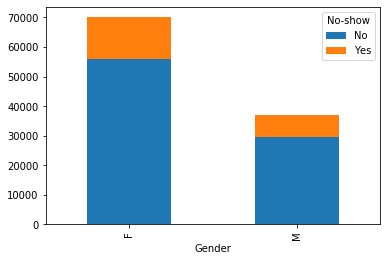

In [14]:
ct = pd.crosstab(noshow.Gender, noshow['No-show'])
ct.plot.bar(stacked=True)
plt.show()

In [15]:
noshow['Scheduled_Day'] = pd.to_datetime(noshow['ScheduledDay'])


In [16]:
noshow['appointment'] = pd.to_datetime(noshow['AppointmentDay'])
noshow['day_of_week'] = noshow['appointment'].dt.day_name()

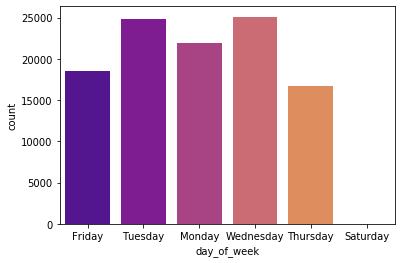

In [17]:
sns.countplot(x='day_of_week', data=noshow, palette = 'plasma')
plt.show()

In [18]:
noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Day,appointment,day_of_week
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,Friday
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,Friday
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,Friday
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,Friday
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,Friday


In [19]:
noshow.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'Scheduled_Day', 'appointment', 'day_of_week'],
      dtype='object')

In [20]:
noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Day,appointment,day_of_week
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,Friday
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,Friday
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,Friday
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,Friday
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,Friday


In [21]:
#Lag between Scheduled day and AppointmentDay

noshow['Lag'] = abs((noshow['appointment'] - noshow['Scheduled_Day']).dt.days)


In [22]:
noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_Day,appointment,day_of_week,Lag
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,Friday,1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,Friday,1
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,Friday,1
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,Friday,1
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,Friday,1


In [23]:

noshow.drop(columns = ['PatientId', 'AppointmentID', 'ScheduledDay','AppointmentDay','appointment','Scheduled_Day'], inplace=True)

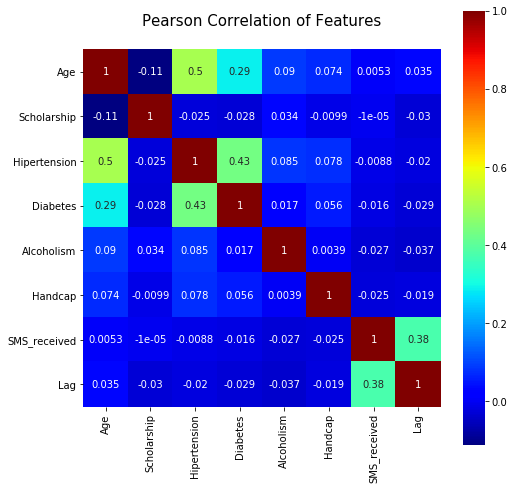

In [24]:
#Correlation Matrix
fig = plt.figure(figsize=[8,8])
plt.title('Pearson Correlation of Features', y=1.05, size=15)

sns.heatmap(noshow.corr(), annot = True, square=True,linecolor='white',cmap='jet' )
plt.show()

In [25]:
y = noshow['No-show']
y.replace('No',0,inplace=True)
y.replace('Yes',1,inplace=True)

In [26]:
noshow.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,day_of_week,Lag
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,Friday,1
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,Friday,1
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,Friday,1
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,Friday,1
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,Friday,1


In [27]:
noshow_dummy = pd.get_dummies(data=noshow.drop(columns='No-show'), columns= ['Neighbourhood','Gender','day_of_week'], drop_first=True)

In [28]:
noshow_dummy.head()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Lag,Neighbourhood_ANDORINHAS,Neighbourhood_ANTÔNIO HONÓRIO,...,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,Gender_M,day_of_week_Monday,day_of_week_Saturday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,62,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,56,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,62,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,56,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
selector = SelectFromModel(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=100)).fit(noshow_dummy, y)
noshow_dummy_robust = selector.transform(noshow_dummy)


In [30]:
noshow_dummy_robust = RobustScaler().fit_transform(noshow_dummy_robust)


In [31]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
noshow_dummy_robust = minmax.fit_transform(noshow_dummy_robust)

In [32]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(noshow_dummy_robust, y)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 85307, 1: 85307})


In [ ]:
model ={'Decision Tree':DecisionTreeClassifier(max_depth=2,min_samples_leaf =10, random_state=0),
       'Random Forest Classifier': RandomForestClassifier(n_estimators=500, max_depth=2, random_state=0),
       'Logistic Regression': LogisticRegression(random_state=0),
       'Gaussian Naive': GaussianNB(),
       'Gradient Boosting': GradientBoostingClassifier(n_estimators=500, max_depth=2, random_state=0)}

for keys, items in model.items():
    cv_results = cross_validate(items, X_res, y_res, cv=5, scoring=('r2', 'f1','precision','recall','roc_auc'))
    print("keys" + "  " + str(keys),"\n")
    print("Recall:  ", cv_results['test_recall'])
    print("Precision:  ", cv_results['test_precision'],"\n")
    print("AUC:  ", cv_results['test_roc_auc'])
    print("max AUC:  ", max(cv_results['test_roc_auc']),"\n")
    print("average AUC:  ", np.mean(cv_results['test_roc_auc']))



keys  Decision Tree 

Recall:   [0.85557705 0.85950413 0.87856054 0.88406986 0.88148409]
Precision:   [0.61870046 0.61082184 0.61712639 0.64214559 0.6309364 ] 

AUC:   [0.6896636  0.67252022 0.70772278 0.73162639 0.70996579]
max AUC:   0.7316263917090757 

average AUC:   0.7022997569406262
keys  Random Forest Classifier 

Recall:   [0.8052283  0.79801887 0.81408979 0.81561364 0.81952992]
Precision:   [0.6253357  0.60873648 0.62384909 0.65162015 0.63341488] 

AUC:   [0.67899714 0.6817006  0.70986999 0.73748811 0.65807742]
max AUC:   0.7374881147818032 

average AUC:   0.6932266528631296
keys  Logistic Regression 

Recall:   [0.55354317 0.57493699 0.55304185 0.56118861 0.5696618 ]
Precision:   [0.63429377 0.62906432 0.6321431  0.67287421 0.59614795] 

AUC:   [0.64673576 0.64279797 0.64055246 0.68506938 0.60887452]
max AUC:   0.685069375444868 

average AUC:   0.6448060182048723
keys  Gaussian Naive 

Recall:   [0.53338022 0.56784479 0.54167155 0.54143711 0.5510228 ]
Precision:   [0.62940